In [61]:
import os
import sys
import netCDF4
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt

In [50]:
file_old = "/home/runnalja/git/Simstrat/operational-simstrat/runs/LakeLucerne-KreuztrichterandVitznauerbecken/Results/T_out.dat"
file_new = "/home/runnalja/git/Simstrat/operational-simstrat/runs/lucernekreuztrichterandvitznauerbecken/Results/T_out.dat"

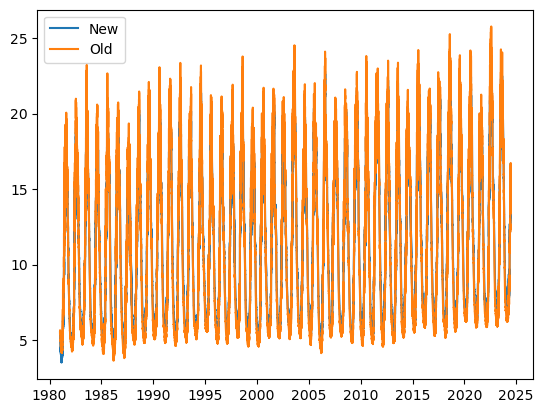

In [51]:
df = pd.read_csv(file_new)
df["Datetime"] = pd.to_datetime(df['Datetime'], origin='19810101', unit='D')
df.set_index('Datetime', inplace=True)
plt.plot(df.index, df.iloc[:, -1], label="New")

df1 = pd.read_csv(file_old)
df1["Datetime"] = pd.to_datetime(df1['Datetime'], origin='19810101', unit='D')
df1.set_index('Datetime', inplace=True)
plt.plot(df1.index, df1.iloc[:, -1], label="Old")

plt.legend()

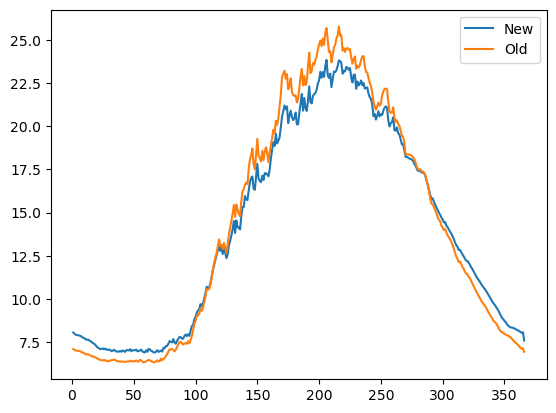

In [52]:
df['day_of_year'] = df.index.dayofyear
doy = df.groupby('day_of_year').max()
plt.plot(doy.index, doy.iloc[:, -1], label="New")

df1['day_of_year'] = df1.index.dayofyear
doy1 = df1.groupby('day_of_year').max()
plt.plot(doy1.index, doy1.iloc[:, -1], label="Old")

plt.legend()

In [117]:
folder = "/home/runnalja/git/Simstrat/operational-simstrat/runs/online/lucernekreuztrichterandvitznauerbecken"
parameter = "T"
depth = 0
out = {}

files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".nc")]
files.sort()
files = files[24:]  # Remove first two years as a warmup
with xr.open_mfdataset(files, parallel=False) as ds:
    if parameter not in ds.variables:
        raise HTTPException(status_code=400, detail="Parameter {} is not available".format(parameter))
    ds['time'] = ds.indexes['time'].tz_localize('UTC')
    ds['time'] = pd.to_datetime(ds['time'].values)
    ds = ds.sel(time=ds['time.year'] != pd.Timestamp.now().year)
    out["unit"] = ds[parameter].units
    if len(ds[parameter].shape) == 2:
        depths = ds.depth[:].values * - 1
        index = get_closest_index(depth, depths)
        out["depth"] = depths[index]
        data = ds[parameter].isel({"depth": index})
    else:
        data = ds[parameter]

    data = data.chunk({'time': -1})
    max_values_doy = data.groupby('time.dayofyear').max(dim='time')
    mean_values_doy = data.groupby('time.dayofyear').mean(dim='time')
    min_values_doy = data.groupby('time.dayofyear').min(dim='time')
    std_values_doy = data.groupby('time.dayofyear').std(dim='time')
    percentile_5_doy = data.groupby('time.dayofyear').quantile(0.05, dim='time')
    percentile_25_doy = data.groupby('time.dayofyear').quantile(0.25, dim='time')
    percentile_75_doy = data.groupby('time.dayofyear').quantile(0.75, dim='time')
    percentile_95_doy = data.groupby('time.dayofyear').quantile(0.95, dim='time')

    last_year = pd.Timestamp.now().year - 1
    data_previous_year = data.sel(time=slice(f'{last_year}-01-01', f'{last_year}-12-31'))
    daily_average_last_year = data_previous_year.groupby('time.dayofyear').mean(dim='time')

In [44]:
def get_closest_index(value, array):
    array = np.asarray(array)
    sorted_array = np.sort(array)
    if len(array) == 0:
        raise ValueError("Array must be longer than len(0) to find index of value")
    elif len(array) == 1:
        return 0
    if value > (2 * sorted_array[-1] - sorted_array[-2]):
        raise HTTPException(status_code=400,
                            detail="Value {} greater than max available ({})".format(value, sorted_array[-1]))
    elif value < (2 * sorted_array[0] - sorted_array[-1]):
        raise HTTPException(status_code=400,
                            detail="Value {} less than min available ({})".format(value, sorted_array[0]))
    return (np.abs(array - value)).argmin()

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 12:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 12:
  #000: H5A.c line 528 in H5

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



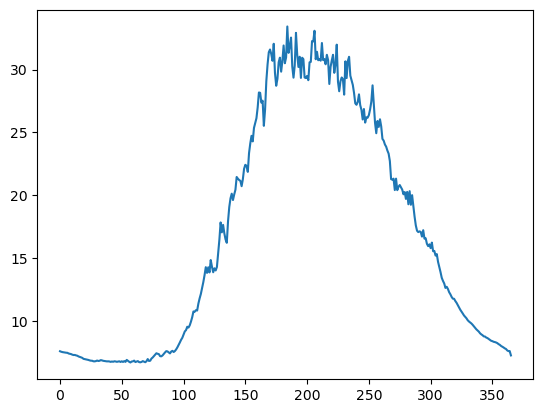

In [57]:
plt.plot(np.array(max_values_doy))

In [116]:
folder = "/home/runnalja/git/Simstrat/operational-simstrat/runs/online/lucernekreuztrichterandvitznauerbecken"
parameter = "T"
depth = 0
out = {}

files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".nc")]
files.sort()
files = files[24:]  # Remove first two years as a warmup


for i, file in enumerate(files):
    with netCDF4.Dataset(file) as nc:
        if i == 0:
            index = get_closest_index(depth, np.array(nc.variables["depth"][:]))
            df = pd.DataFrame({'time': nc.variables["time"][:],'value': nc.variables[parameter][index, :]})
        else:
            df_new = pd.DataFrame({'time': nc.variables["time"][:],'value': nc.variables[parameter][index, :]})
            df = pd.concat([df, df_new])
df["time"] = pd.to_datetime(df['time'], unit='s', utc=True)
df.set_index('time', inplace=True)
grouped = df.groupby(df.index.dayofyear)['value']
max_values_doy = grouped.max()
mean_values_doy = grouped.mean()
min_values_doy = grouped.min()
std_values_doy = grouped.std()
percentile_5_doy = grouped.quantile(0.05)
percentile_25_doy = grouped.quantile(0.25)
percentile_75_doy = grouped.quantile(0.75)
percentile_95_doy = grouped.quantile(0.95)

last_year = pd.Timestamp.now().year - 1
df_previous_year = df[f'{last_year}-01-01':f'{last_year}-12-31']
daily_average_last_year = df_previous_year.groupby(df_previous_year.index.dayofyear)['value'].mean()

In [114]:
filter_parameter(daily_average_last_year.values)

[7.547,
 7.521,
 7.512,
 7.488,
 7.473,
 7.448,
 7.425,
 7.392,
 7.362,
 7.332,
 7.302,
 7.279,
 7.26,
 7.238,
 7.218,
 7.162,
 7.125,
 7.083,
 7.021,
 6.964,
 6.948,
 6.93,
 6.902,
 6.873,
 6.853,
 6.825,
 6.789,
 6.754,
 6.728,
 6.698,
 6.699,
 6.69,
 6.693,
 6.694,
 6.688,
 6.673,
 6.648,
 6.609,
 6.575,
 6.549,
 6.531,
 6.517,
 6.514,
 6.503,
 6.488,
 6.486,
 6.503,
 6.503,
 6.55,
 6.561,
 6.577,
 6.595,
 6.601,
 6.627,
 6.66,
 6.614,
 6.518,
 6.447,
 6.422,
 6.424,
 6.459,
 6.438,
 6.471,
 6.429,
 6.413,
 6.44,
 6.426,
 6.5,
 6.503,
 6.453,
 6.461,
 6.523,
 6.522,
 6.547,
 6.578,
 6.636,
 6.712,
 6.735,
 6.748,
 6.81,
 6.938,
 6.981,
 6.965,
 6.952,
 6.941,
 6.871,
 6.915,
 6.946,
 7.001,
 7.022,
 7.01,
 7.044,
 6.981,
 6.937,
 7.005,
 7.068,
 7.041,
 7.071,
 7.168,
 7.293,
 7.286,
 7.325,
 7.309,
 7.409,
 7.383,
 7.322,
 7.379,
 7.515,
 7.525,
 7.44,
 7.475,
 7.634,
 7.784,
 7.847,
 7.865,
 8.003,
 8.247,
 8.311,
 8.496,
 8.497,
 8.5,
 8.595,
 8.771,
 9.198,
 9.6,
 9.981,
 10.073

In [108]:
def filter_parameter(x, decimals=3, string=False, nodata=-999.0):
    x = np.asarray(x).astype(float)
    x[x == nodata] = None
    out = np.around(x, decimals=decimals)
    out = np.where(np.isnan(out), None, out)
    if string:
        return json.dumps(out.tolist())
    else:
        return out.tolist()